In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')
 
series = pd.read_csv("../data/demo_data/metric/arima_ts_example.csv", header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
plt.show()

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
pyplot.show()

In [ ]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())


In [ ]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series.index = series.index.to_period('M')
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# one time predict
one_time_model = ARIMA(history, order=(5,1,0))
one_time_model_fit = one_time_model.fit()
one_time_output = one_time_model_fit.forecast(12)
one_time_predictions = one_time_output

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test,color="blue")
pyplot.plot(predictions, color='red')
pyplot.plot(one_time_predictions, color='green')
pyplot.show()


## 基于grid search的搜索

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q) 
def evaluate_arima_model(X, arima_order):
    # prepare training dataset 
    train_size = int(len(X) * 0.66) 
    train, test = X[0:train_size], X[train_size:] 
    history = [x for x in train] # make predictions 
    predictions = list() 
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t]) # calculate out-of-sample error 
    rmse = sqrt(mean_squared_error(test, predictions)) 
    return rmse

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model 
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32') 
    best_score, best_cfg = float("inf"), None 
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q) 
                try:
                    rmse = evaluate_arima_model(dataset, order) 
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order 
                    print('ARIMA%s RMSE=%.3f' % (order,rmse)) 
                except Exception as e:
                    print(e)
                    continue 
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
# evaluate parameters 
p_values = [0, 1, 2, 4, 6, 8, 10] 
d_values = range(0, 3) 
q_values = range(0, 3) 
warnings.filterwarnings("ignore") 
evaluate_models(series.values, p_values, d_values, q_values)

## prophet

In [33]:
import pandas as pd
import datetime 
import numpy as np
import matplotlib.pyplot as plt
# 读入数据
df=pd.read_csv("../data/demo_data/metric/art_daily_jumpsup.csv")
df=df[["timestamp","value"]]
# 提取一段时间序列
ts=df.iloc[:300,:]
# 拆分训练集和测试集
train_ts=ts.iloc[:250,:]
test_ts=ts.iloc[250:,:]

In [39]:
ts

,timestamp,value
0,2014-04-01 00:00:00,19.761252
1,2014-04-01 00:05:00,20.500833
2,2014-04-01 00:10:00,19.961641
3,2014-04-01 00:15:00,21.490266
4,2014-04-01 00:20:00,20.187739
...,...,...
295,2014-04-02 00:35:00,19.756282
296,2014-04-02 00:40:00,21.801342
297,2014-04-02 00:45:00,20.893160
298,2014-04-02 00:50:00,18.282673


In [34]:
from prophet import Prophet
train_ts=train_ts.rename(columns={"timestamp":"ds","value":"y"})
train_ts["ds"]=pd.to_datetime(train_ts["ds"])


In [43]:
m = Prophet()
m.fit(train_ts)
future = m.make_future_dataframe(periods=50,freq="5min")
forecast = m.predict(future)
fig1 = m.plot(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -27.0988
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       246.808    0.00447327       82.9032   5.977e-05       0.001      132  LS failed, Hessian reset 
      99       247.734    0.00820346       70.1896      0.9855      0.9855      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       249.246   0.000466001       54.2656           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       249.482   5.60491e-05         51.79   9.436e-07       0.001      375  LS failed, Hessian reset 
     296       249.776   7.77512e-05       53.7726   1.504e-06       0.001      491  LS failed, Hessian reset 
     299       249.778   4.42878e-05       47.8621      0.3623           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

,ds,yhat,yhat_lower,yhat_upper
295,2014-04-02 00:35:00,-14.872047,-31.982261,3.000587
296,2014-04-02 00:40:00,-15.725888,-33.436177,1.690737
297,2014-04-02 00:45:00,-16.579729,-34.944479,3.723410
298,2014-04-02 00:50:00,-17.433570,-36.816170,1.277023
299,2014-04-02 00:55:00,-18.287411,-37.509157,1.257987


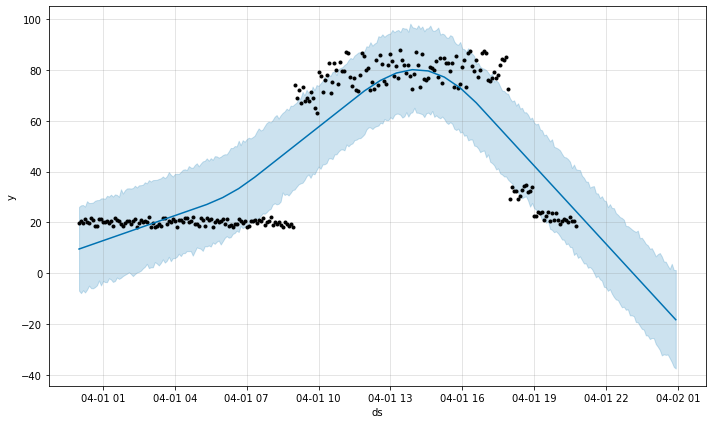